In [2]:
import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Chemin vers la racine du projet
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))  # remonte d'un dossier
data_path = os.path.join(project_root, 'data')

print("Chemin vers data :", data_path)
train_df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'test_ratings.csv'))
df_movies = pd.read_csv(os.path.join(data_path, 'movies.csv'))


# chargemnt des encoder et décoder 
import pickle

with open(os.path.join(data_path, 'user_encoder.pkl'), 'rb') as f:
    user_encoder = pickle.load(f)

with open(os.path.join(data_path, 'movie_encoder.pkl'), 'rb') as f:
    movie_encoder = pickle.load(f)



Chemin vers data : /home/jupyter/Fatma_Aziz/movie_recommender/data


In [3]:
"""
Analyse pour déterminer le seuil optimal de ratings pour le cold start.

Ce script analyse comment la performance du modèle évolue selon le nombre
de ratings par utilisateur, permettant de définir un seuil empirique
pour la transition Popular → Hybrid → Personalized.
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD, accuracy
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Définir le dossier d'analyse
project_root = os.path.abspath('.')
print(f"📁 Racine du projet: {project_root}")
analysis_path = os.path.join(project_root, 'cold_start_analysis')
os.makedirs(analysis_path, exist_ok=True)

# ============================================================================
# FONCTION 1 : ANALYSE PAR NOMBRE DE RATINGS
# ============================================================================

def analyze_performance_by_num_ratings(
    algo,
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    user_encoder,
    movie_encoder,
    max_ratings: int = 50,
    step: int = 1
) -> pd.DataFrame:
    """
    Analyse comment RMSE/MAE évoluent selon le nombre de ratings par utilisateur.
    """
    print("🔍 Analyse de la performance par nombre de ratings...")
    
    # Préparer le dataset Surprise
    reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
    train_data = Dataset.load_from_df(
        train_df[['user_idx', 'movie_idx', 'rating']], 
        reader
    )
    trainset = train_data.build_full_trainset()
    
    # Entraîner le modèle
    print("⏳ Training model...")
    algo.fit(trainset)
    print("✓ Model trained")
    
    # Compter les ratings par utilisateur dans train
    user_rating_counts = train_df.groupby('user_idx').size()
    
    results = []
    
    for n_ratings in range(1, max_ratings + 1, step):
        users_with_n_ratings = user_rating_counts[
            (user_rating_counts >= n_ratings) & 
            (user_rating_counts < n_ratings + step)
        ].index.tolist()
        
        if len(users_with_n_ratings) == 0:
            continue
        
        test_subset = test_df[test_df['user_idx'].isin(users_with_n_ratings)]
        
        if len(test_subset) == 0:
            continue
        
        # Prédictions
        testset = list(zip(
            test_subset['user_idx'], 
            test_subset['movie_idx'], 
            test_subset['rating']
        ))
        predictions = algo.test(testset)
        
        # Calculer RMSE et MAE
        rmse = accuracy.rmse(predictions, verbose=False)
        mae = accuracy.mae(predictions, verbose=False)
        
        # Calculer l'écart-type des erreurs
        errors = [abs(pred.est - pred.r_ui) for pred in predictions]
        std_error = np.std(errors)
        
        results.append({
            'num_ratings': n_ratings,
            'rmse': rmse,
            'mae': mae,
            'std_error': std_error,
            'num_users': len(users_with_n_ratings),
            'num_predictions': len(predictions)
        })
        
        if n_ratings % 10 == 0:
            print(f"  ✓ Analyzed {n_ratings} ratings: RMSE={rmse:.3f}, Users={len(users_with_n_ratings)}")
    
    df_results = pd.DataFrame(results)
    print(f"✓ Analysis complete: {len(df_results)} data points")
    
    return df_results

# ============================================================================
# FONCTION 2 : DÉTERMINER LE SEUIL OPTIMAL
# ============================================================================

def find_optimal_threshold(
    results_df: pd.DataFrame,
    stability_window: int = 5,
    rmse_improvement_threshold: float = 0.05
) -> Dict[str, float]:
    """
    Détermine le seuil optimal où le modèle devient fiable.
    """
    print("\n🎯 Détermination du seuil optimal...")
    
    results_df['rmse_improvement'] = results_df['rmse'].diff().abs()
    
    results_df['rmse_rolling_mean'] = results_df['rmse'].rolling(
        window=stability_window, min_periods=1
    ).mean()
    
    results_df['rmse_rolling_std'] = results_df['rmse'].rolling(
        window=stability_window, min_periods=1
    ).std()
    
    # Trouver où RMSE se stabilise
    stable_points = results_df[
        (results_df['rmse_rolling_std'] < 0.05) &
        (results_df['rmse_improvement'] < rmse_improvement_threshold) &
        (results_df['num_users'] >= 10)
    ]
    
    if len(stable_points) > 0:
        optimal_threshold = stable_points.iloc[0]['num_ratings']
    else:
        final_rmse = results_df.iloc[-1]['rmse']
        target_rmse = final_rmse * 1.1
        optimal_threshold = results_df[results_df['rmse'] <= target_rmse].iloc[0]['num_ratings']
    
    # Recommandations pour les différents seuils
    thresholds = {
        'optimal': optimal_threshold,
        'conservative': max(1, optimal_threshold * 0.7),
        'aggressive': optimal_threshold * 1.3
    }
    
    print(f"\n📊 Seuils recommandés :")
    print(f"  • Conservative (transition tôt)  : {thresholds['conservative']:.0f} ratings")
    print(f"  • Optimal (équilibre)            : {thresholds['optimal']:.0f} ratings")
    print(f"  • Aggressive (transition tard)   : {thresholds['aggressive']:.0f} ratings")
    
    # Statistiques au seuil optimal
    optimal_row = results_df[results_df['num_ratings'] == optimal_threshold]
    if len(optimal_row) > 0:
        optimal_row = optimal_row.iloc[0]
        print(f"\n📈 Performance au seuil optimal ({optimal_threshold:.0f} ratings) :")
        print(f"  • RMSE : {optimal_row['rmse']:.3f}")
        print(f"  • MAE  : {optimal_row['mae']:.3f}")
        print(f"  • STD  : {optimal_row['std_error']:.3f}")
        print(f"  • Users: {optimal_row['num_users']:.0f}")
    else:
        print(f"\n⚠️  Pas de données exactes pour le seuil {optimal_threshold}")
    
    return thresholds

# ============================================================================
# FONCTION 3 : VISUALISATIONS
# ============================================================================

def plot_cold_start_analysis(
    results_df: pd.DataFrame,
    thresholds: Dict[str, float],
    save_path: str = None
):
    """
    Crée des visualisations complètes de l'analyse cold start.
    """
    if save_path is None:
        save_path = os.path.join(analysis_path, 'cold_start_analysis.png')
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Style
    sns.set_style("whitegrid")
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    
    # 1. RMSE avec zones de stratégies
    ax1 = axes[0, 0]
    optimal = thresholds['optimal']
    
    ax1.plot(results_df['num_ratings'], results_df['rmse'], 
             linewidth=2.5, color='#2c3e50', label='RMSE')
    
    # Zones de stratégies
    ax1.axvspan(0, optimal, alpha=0.2, color=colors[1], label='Hybrid Zone')
    ax1.axvspan(optimal, results_df['num_ratings'].max(), 
                alpha=0.2, color=colors[0], label='Personalized Zone')
    ax1.axvline(optimal, color='red', linestyle='--', linewidth=2, 
                label=f'Seuil optimal ({optimal:.0f})')
    
    ax1.set_xlabel('Nombre de ratings par utilisateur', fontsize=12, weight='bold')
    ax1.set_ylabel('RMSE', fontsize=12, weight='bold')
    ax1.set_title('Évolution de l\'erreur (RMSE) selon le nombre de ratings',
                  fontsize=13, weight='bold', pad=15)
    ax1.legend(fontsize=10, loc='upper right')
    ax1.grid(alpha=0.3)
    
    # 2. MAE
    ax2 = axes[0, 1]
    ax2.plot(results_df['num_ratings'], results_df['mae'], 
             linewidth=2.5, color='#e67e22', label='MAE')
    ax2.axvline(optimal, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Nombre de ratings par utilisateur', fontsize=12, weight='bold')
    ax2.set_ylabel('MAE', fontsize=12, weight='bold')
    ax2.set_title('Évolution de l\'erreur absolue moyenne (MAE)',
                  fontsize=13, weight='bold', pad=15)
    ax2.grid(alpha=0.3)
    
    # 3. Écart-type
    ax3 = axes[1, 0]
    ax3.plot(results_df['num_ratings'], results_df['std_error'], 
             linewidth=2.5, color='#9b59b6', label='Écart-type des erreurs')
    ax3.axvline(optimal, color='red', linestyle='--', linewidth=2)
    ax3.axhspan(0, 1.0, alpha=0.15, color='green', label='Variance acceptable')
    ax3.set_xlabel('Nombre de ratings par utilisateur', fontsize=12, weight='bold')
    ax3.set_ylabel('Écart-type des erreurs', fontsize=12, weight='bold')
    ax3.set_title('Variance des prédictions',
                  fontsize=13, weight='bold', pad=15)
    ax3.legend(fontsize=10)
    ax3.grid(alpha=0.3)
    
    # 4. Distribution des utilisateurs
    ax4 = axes[1, 1]
    ax4.bar(results_df['num_ratings'], results_df['num_users'], 
            color='#34495e', alpha=0.7, edgecolor='black')
    ax4.axvline(optimal, color='red', linestyle='--', linewidth=2)
    ax4.set_xlabel('Nombre de ratings par utilisateur', fontsize=12, weight='bold')
    ax4.set_ylabel('Nombre d\'utilisateurs', fontsize=12, weight='bold')
    ax4.set_title('Distribution du nombre d\'utilisateurs',
                  fontsize=13, weight='bold', pad=15)
    ax4.grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Graphique sauvegardé : {save_path}")
    plt.show()

# ============================================================================
# FONCTION 4 : COMPARAISON DE MODÈLES
# ============================================================================

def compare_models_cold_start(
    models: Dict,
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    user_encoder,
    movie_encoder,
    max_ratings: int = 30
) -> pd.DataFrame:
    """
    Compare plusieurs modèles sur leur gestion du cold start.
    """
    print("\n🔄 Comparaison de plusieurs modèles...")
    
    all_results = []
    
    for model_name, algo in models.items():
        print(f"\n📊 Analyse : {model_name}")
        
        results = analyze_performance_by_num_ratings(
            algo=algo,
            train_df=train_df,
            test_df=test_df,
            user_encoder=user_encoder,
            movie_encoder=movie_encoder,
            max_ratings=max_ratings,
            step=2
        )
        
        results['model'] = model_name
        all_results.append(results)
    
    comparison_df = pd.concat(all_results, ignore_index=True)
    
    return comparison_df

def plot_model_comparison(
    comparison_df: pd.DataFrame,
    save_path: str = None
):
    """
    Visualise la comparaison de modèles pour le cold start.
    """
    if save_path is None:
        save_path = os.path.join(analysis_path, 'model_comparison_cold_start.png')
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Palette de couleurs
    models = comparison_df['model'].unique()
    palette = sns.color_palette("husl", len(models))
    
    # Graphique 1 : RMSE par modèle
    ax1 = axes[0]
    for i, model in enumerate(models):
        model_data = comparison_df[comparison_df['model'] == model]
        ax1.plot(model_data['num_ratings'], model_data['rmse'], 
                linewidth=2.5, label=model, color=palette[i], marker='o', markersize=4)
    
    ax1.set_xlabel('Nombre de ratings par utilisateur', fontsize=12, weight='bold')
    ax1.set_ylabel('RMSE', fontsize=12, weight='bold')
    ax1.set_title('Comparaison RMSE : Performance selon le cold start',
                  fontsize=13, weight='bold', pad=15)
    ax1.legend(fontsize=10, loc='best')
    ax1.grid(alpha=0.3)
    
    # Graphique 2 : MAE par modèle
    ax2 = axes[1]
    for i, model in enumerate(models):
        model_data = comparison_df[comparison_df['model'] == model]
        ax2.plot(model_data['num_ratings'], model_data['mae'], 
                linewidth=2.5, label=model, color=palette[i], marker='o', markersize=4)
    
    ax2.set_xlabel('Nombre de ratings par utilisateur', fontsize=12, weight='bold')
    ax2.set_ylabel('MAE', fontsize=12, weight='bold')
    ax2.set_title('Comparaison MAE : Erreur absolue moyenne',
                  fontsize=13, weight='bold', pad=15)
    ax2.legend(fontsize=10, loc='best')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Graphique sauvegardé : {save_path}")
    plt.show()

📁 Racine du projet: /home/jupyter/Fatma_Aziz/movie_recommender/notebooks


  ANALYSE COLD START - DÉTERMINATION DU SEUIL OPTIMAL

📌 Phase 1 : Analyse approfondie avec SVD
🔍 Analyse de la performance par nombre de ratings...
⏳ Training model...
✓ Model trained
  ✓ Analyzed 20 ratings: RMSE=1.110, Users=11
  ✓ Analyzed 30 ratings: RMSE=0.935, Users=7
  ✓ Analyzed 40 ratings: RMSE=1.122, Users=10
  ✓ Analyzed 50 ratings: RMSE=0.986, Users=5
✓ Analysis complete: 39 data points

🎯 Détermination du seuil optimal...

📊 Seuils recommandés :
  • Conservative (transition tôt)  : 8 ratings
  • Optimal (équilibre)            : 11 ratings
  • Aggressive (transition tard)   : 14 ratings

📈 Performance au seuil optimal (11 ratings) :
  • RMSE : 0.938
  • MAE  : 0.786
  • STD  : 0.512
  • Users: 1
✓ Graphique sauvegardé : /home/jupyter/Fatma_Aziz/movie_recommender/notebooks/cold_start_analysis/cold_start_analysis.png


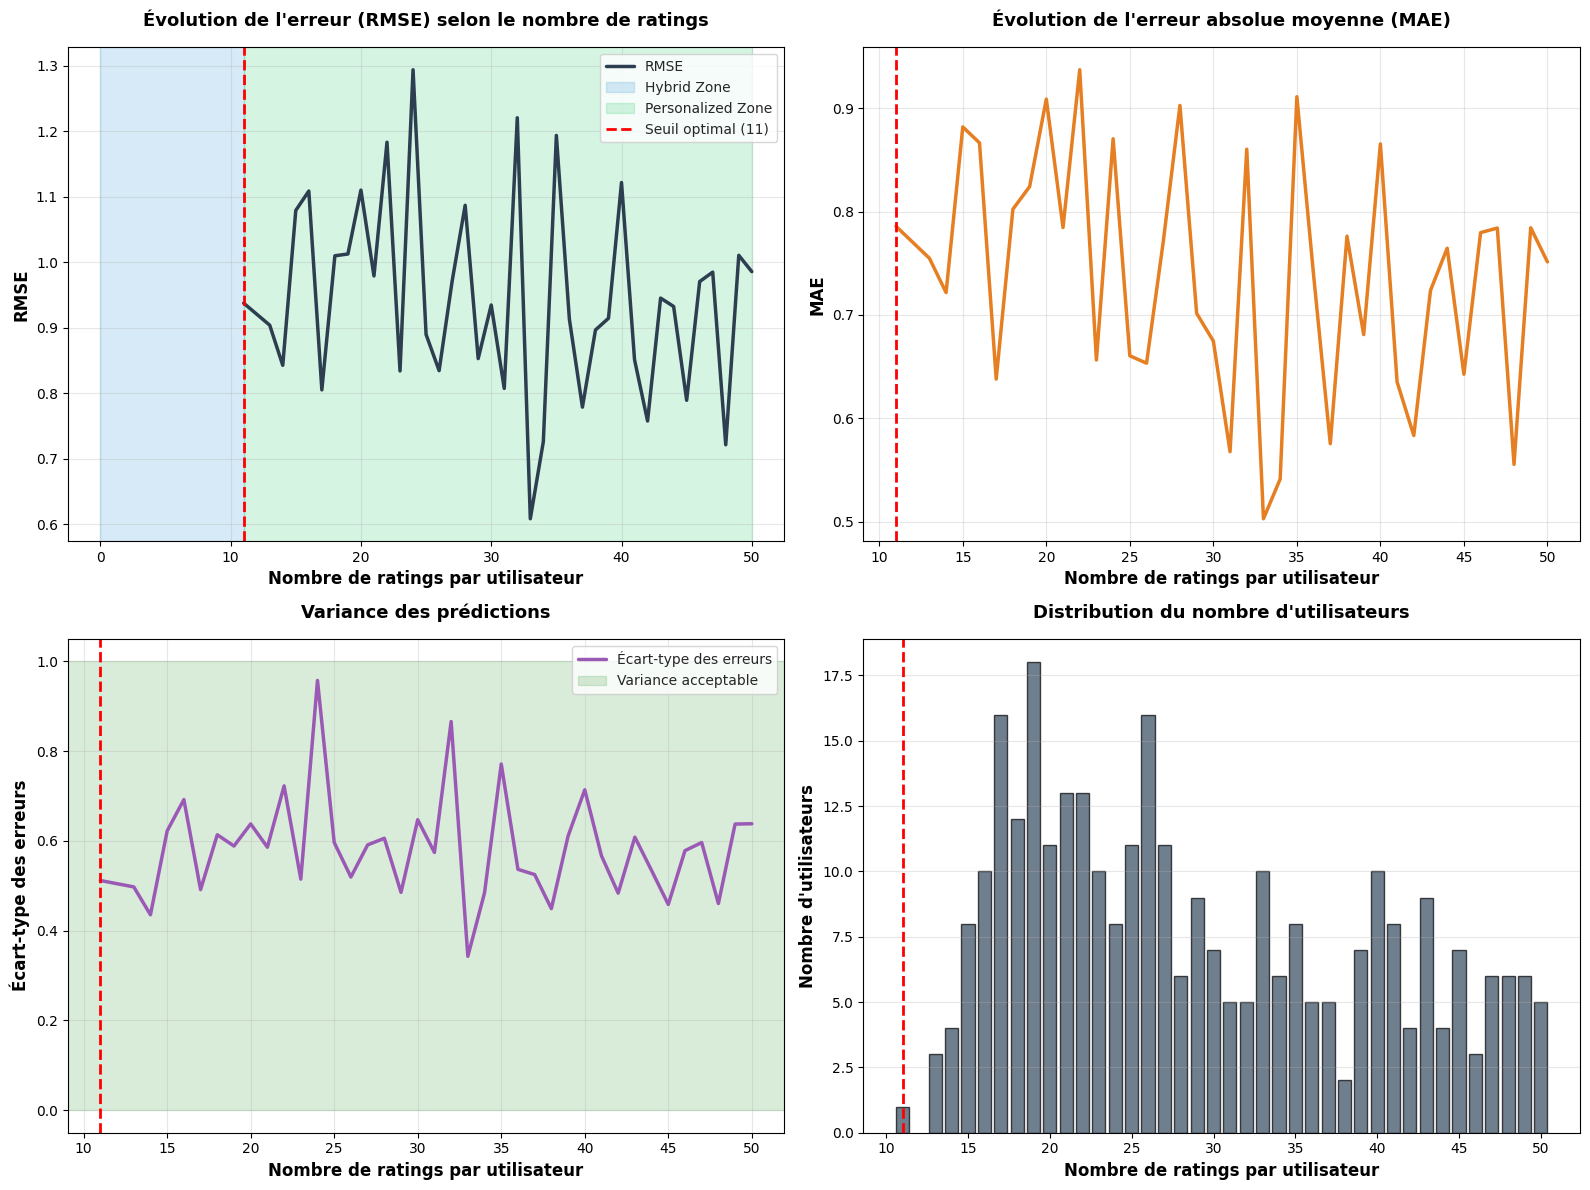


📌 Phase 2 : Comparaison de modèles

🔄 Comparaison de plusieurs modèles...

📊 Analyse : SVD
🔍 Analyse de la performance par nombre de ratings...
⏳ Training model...
✓ Model trained
✓ Analysis complete: 10 data points

📊 Analyse : SVD++
🔍 Analyse de la performance par nombre de ratings...
⏳ Training model...
✓ Model trained
✓ Analysis complete: 10 data points

📊 Analyse : KNN User-Based
🔍 Analyse de la performance par nombre de ratings...
⏳ Training model...
Computing the cosine similarity matrix...
Done computing similarity matrix.
✓ Model trained
✓ Analysis complete: 10 data points

📊 Analyse : KNN Item-Based
🔍 Analyse de la performance par nombre de ratings...
⏳ Training model...
Computing the cosine similarity matrix...
Done computing similarity matrix.
✓ Model trained
✓ Analysis complete: 10 data points

📊 Analyse : NMF
🔍 Analyse de la performance par nombre de ratings...
⏳ Training model...
✓ Model trained
✓ Analysis complete: 10 data points
✓ Graphique sauvegardé : /home/jupyter/

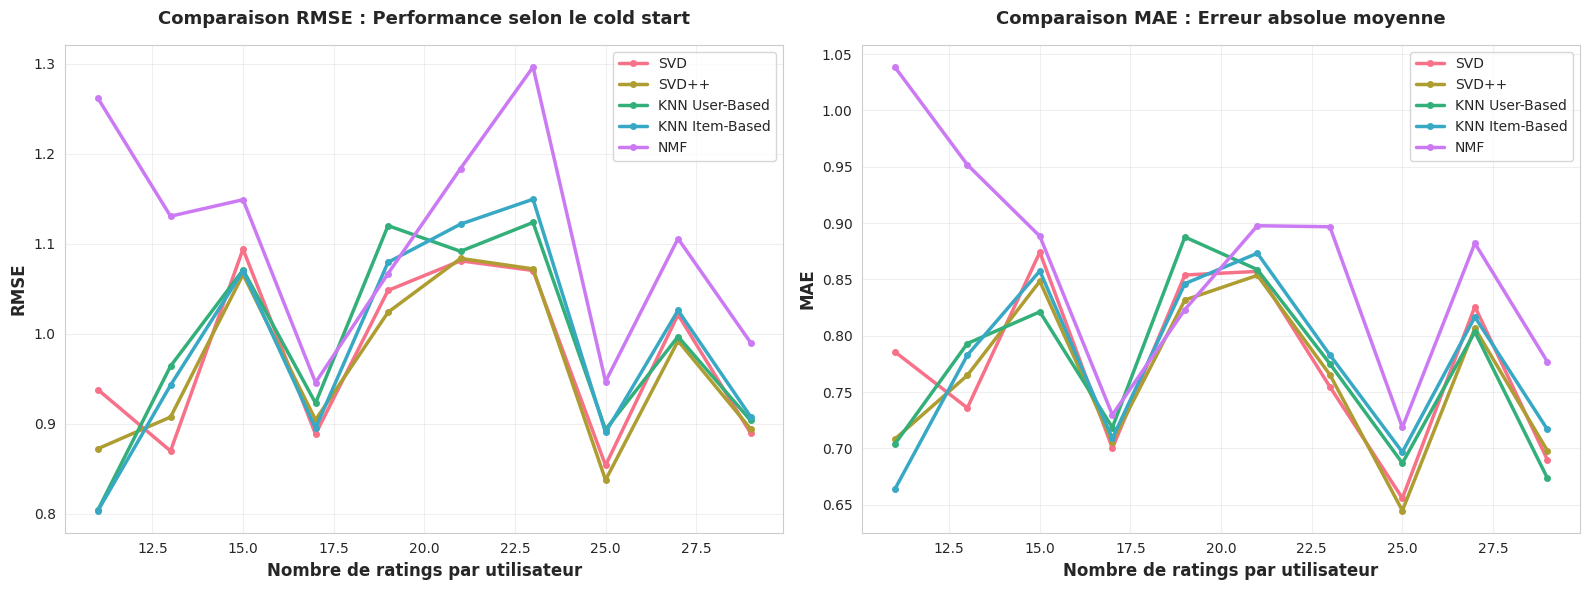


📊 Exportation des résultats...


NameError: name '__file__' is not defined

In [4]:
if __name__ == "__main__":
    from surprise import SVD, SVDpp, KNNBasic, KNNWithMeans, NMF
    
    print("="*60)
    print("  ANALYSE COLD START - DÉTERMINATION DU SEUIL OPTIMAL")
    print("="*60)
    
    # ─────────────────────────────────────────────────────────
    # 1. ANALYSE D'UN SEUL MODÈLE (SVD)
    # ─────────────────────────────────────────────────────────
    print("\n📌 Phase 1 : Analyse approfondie avec SVD")
    
    algo_svd = SVD(n_factors=50, n_epochs=20, random_state=42)
    
    results_svd = analyze_performance_by_num_ratings(
        algo=algo_svd,
        train_df=train_df,
        test_df=test_df,
        user_encoder=user_encoder,
        movie_encoder=movie_encoder,
        max_ratings=50,
        step=1
    )
    
    # Déterminer le seuil optimal
    thresholds = find_optimal_threshold(results_svd)
    
    # Visualiser
    plot_cold_start_analysis(results_svd, thresholds)
    
    # ─────────────────────────────────────────────────────────
    # 2. COMPARAISON DE MODÈLES
    # ─────────────────────────────────────────────────────────
    print("\n📌 Phase 2 : Comparaison de modèles")
    
    models_to_compare = {
        "SVD": SVD(n_factors=50, n_epochs=20, random_state=42),
        "SVD++": SVDpp(n_factors=20, n_epochs=20, random_state=42),
        "KNN User-Based": KNNWithMeans(k=40, sim_options={'name': 'cosine', 'user_based': True}),
        "KNN Item-Based": KNNWithMeans(k=40, sim_options={'name': 'cosine', 'user_based': False}),
        "NMF": NMF(n_factors=15, n_epochs=50, random_state=42)
    }
    
    comparison_results = compare_models_cold_start(
        models=models_to_compare,
        train_df=train_df,
        test_df=test_df,
        user_encoder=user_encoder,
        movie_encoder=movie_encoder,
        max_ratings=30
    )
    
    # Visualiser la comparaison
    # Utiliser le même dossier d'analyse
    comparison_save_path = os.path.join(analysis_path, 'model_comparison_cold_start.png')
    plot_model_comparison(comparison_results, save_path=comparison_save_path)
    

In [8]:
    # ─────────────────────────────────────────────────────────
    # 3. EXPORTER LES RÉSULTATS
    # ─────────────────────────────────────────────────────────
    print("\n📊 Exportation des résultats...")
    
    # Sauvegarder dans le dossier d'analyse
    results_svd.to_csv(os.path.join(analysis_path, 'cold_start_analysis_svd.csv'), index=False)
    comparison_results.to_csv(os.path.join(analysis_path, 'cold_start_comparison.csv'), index=False)
    
    import os

    # 1. Obtenir le chemin du dossier actuel (notebooks/)
    current_dir = os.getcwd()  # Récupère le dossier courant
    print(f"Dossier actuel: {current_dir}")

    # # 2. Remonter d'un niveau (vers movie_recommender/)
    # project_root = os.path.dirname(current_dir)
    # print(f"Racine projet: {project_root}")  # /chemin/movie_recommender

    # 3. Créer config/ au même niveau que api/
    config_dir = os.path.join(project_root,'api', 'config')
    os.makedirs(config_dir, exist_ok=True)
    print(f"Dossier config créé: {config_dir}")  # /chemin/movie_recommender/config
    
    # Sauvegarder les seuils recommandés
    threshold_file = os.path.join(config_dir, 'cold_start_threshold.txt')
    with open(threshold_file, 'w') as f:
        f.write(f"# Seuils déterminés empiriquement\n")
        f.write(f"THRESHOLD_HYBRID = {int(thresholds['optimal'])}\n")
        f.write(f"THRESHOLD_CONSERVATIVE = {int(thresholds['conservative'])}\n")
        f.write(f"THRESHOLD_AGGRESSIVE = {int(thresholds['aggressive'])}\n")
    
    print("✓ Résultats exportés")
    
    print("\n" + "="*60)
    print("  ANALYSE TERMINÉE")
    print("="*60)
    print(f"\n🎯 RECOMMANDATION : Utiliser {int(thresholds['optimal'])} ratings")
    print(f"   comme seuil dans api/app.py")
    print("\n📁 Fichiers générés :")
    print(f"   • {os.path.join(analysis_path, 'cold_start_analysis.png')}")
    print(f"   • {os.path.join(analysis_path, 'model_comparison_cold_start.png')}")
    print(f"   • {os.path.join(analysis_path, 'cold_start_analysis_svd.csv')}")
    print(f"   • {threshold_file}")


📊 Exportation des résultats...
Dossier actuel: /home/jupyter/Fatma_Aziz/movie_recommender/notebooks
Dossier config créé: /home/jupyter/Fatma_Aziz/movie_recommender/api/config
✓ Résultats exportés

  ANALYSE TERMINÉE

🎯 RECOMMANDATION : Utiliser 11 ratings
   comme seuil dans api/app.py

📁 Fichiers générés :
   • /home/jupyter/Fatma_Aziz/movie_recommender/notebooks/cold_start_analysis/cold_start_analysis.png
   • /home/jupyter/Fatma_Aziz/movie_recommender/notebooks/cold_start_analysis/model_comparison_cold_start.png
   • /home/jupyter/Fatma_Aziz/movie_recommender/notebooks/cold_start_analysis/cold_start_analysis_svd.csv
   • /home/jupyter/Fatma_Aziz/movie_recommender/api/config/cold_start_threshold.txt
